## Udacity Set to Coco

In [1]:
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
print(sys.path)

['', '/home/dean/anaconda3/envs/ros-kache/lib/python35.zip', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/plat-linux', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/lib-dynload', '/home/dean/.local/lib/python3.5/site-packages', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages', '/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages/IPython/extensions', '/home/dean/.ipython']


In [2]:
## Imports

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image

import scipy.misc
from skimage import measure   

import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
import pandas as pd

/home/dean/anaconda3/envs/ros-kache/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
## RoadCOCO Dataset Labels
WORKING_DIRECTORY = '/media/dean/49D9D6EB1BE53FC4/datasets/Scripts/'
RoadCOCO_LABELS_PATH = os.path.join(WORKING_DIRECTORY,'RoadCOCO_Classes.csv')
GT_HEADER_ROW = ['class', 'super-category', 'special', 'description']


In [7]:
# Get RoadCOCO Labels to Use as Ground Truth
gt_labels = pd.read_csv(RoadCOCO_LABELS_PATH, names=GT_HEADER_ROW, skiprows=1)
gt_labels.head()

,class,super-category,special,description
0,Vehicle,Vehicle,Orientation matters,Combination of all other vehicles to get a cat...
1,Car,Vehicle,Orientation matters,NaN
2,Pickup,Truck,Orientation matters,NaN
3,TractorSemi,Truck,Orientation matters,NaN
4,TrailerSemi,Truck,Orientation matters,NaN


In [8]:
# Represent Category IDs using RoadCOCO Labels
cats2ids = {}
for i, label in enumerate(sorted(set(gt_labels['class'].tolist()))):
    cats2ids[str(label).lower()] = i
ids2cats = {i: v for v, i in cats2ids.items()}
    


# Build Categories List in MS RoadCOCO Format
coco_categories = [] 
for label in gt_labels.as_matrix():
    category = str(label[0]).lower()
    cat_id = cats2ids[category]
    
    
    # Verify super-category in list, handle edge cases
    if str(label[1]).lower() == 'truck':
        sup_cat = ids2cats[cats2ids['utilitytruck']]
    elif str(label[1]).lower() == 'constructionfurniture':
        sup_cat = ids2cats[cats2ids['constructionequipment']]
    elif str(label[1]).lower() == 'pedestrian':
        sup_cat = ids2cats[cats2ids['person']]
    else:
        sup_cat = ids2cats[cats2ids[str(label[1]).lower()]]
    
    coco_categories.append({"id": cat_id, "name": category, "supercategory":sup_cat})   
print (coco_categories)

[{'id': 62, 'name': 'vehicle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 37, 'name': 'pickup', 'supercategory': 'utilitytruck'}, {'id': 52, 'name': 'tractorsemi', 'supercategory': 'utilitytruck'}, {'id': 60, 'name': 'trailersemi', 'supercategory': 'utilitytruck'}, {'id': 21, 'name': 'firetruck', 'supercategory': 'utilitytruck'}, {'id': 0, 'name': 'ambulance', 'supercategory': 'utilitytruck'}, {'id': 39, 'name': 'police', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'constructionequipment', 'supercategory': 'constructionequipment'}, {'id': 34, 'name': 'motorcycle', 'supercategory': 'vehicle'}, {'id': 43, 'name': 'scooter', 'supercategory': 'person'}, {'id': 4, 'name': 'bicyclist', 'supercategory': 'vehicle'}, {'id': 20, 'name': 'escooter', 'supercategory': 'vehicle'}, {'id': 45, 'name': 'skateboard', 'supercategory': 'misc_label'}, {'id': 64, 'name': 'wheelchair', 'supercategory': 'person'}, {'id': 51, 'name': 'stroller', 'supercategory

/home/dean/anaconda3/envs/ros-kache/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

In [33]:
# Script to convert LabelME XML Annotations to Coco Json Annotations
import xml.etree.cElementTree as ET
import glob
import argparse
import os
import numpy as np
import json
import numpy
import cv2
from shapely.geometry import Polygon, MultiPolygon, MultiPoint

from PIL import Image


WORKING_DIRECTORY = '/media/dean/49D9D6EB1BE53FC4/datasets/labelme'
ann_index = 0
anns, images = [], []
annotations = "{}{}{}{}".format(WORKING_DIRECTORY,'**/','**/', '*.xml')

for annotation in glob.glob(annotations, recursive=True):
    print(annotation)
    annotation_xml = ET.parse(annotation)


    annotation_node = annotation_xml.getroot()
    img_filename = annotation_node.find('filename')
    folder = annotation_node.find('folder')
    img_filepath = os.path.join(str(getvalueofnode(folder)),str(getvalueofnode(img_filename)))

    # Parse Detections
    detection_node = annotation_node.find('object')
    if detection_node:
        img_label = getvalueofnode(detection_node.find('name'))
    else:
        img_label = ''

    polygon_node = detection_node.find('polygon')

    pts = []
    for i,pt in enumerate(polygon_node):

        if pt.tag.lower() != 'username':
            x,y = getvalueofnode(pt.find('x')), getvalueofnode(pt.find('y'))
            pts.append((float(x),float(y)))


    # Convert XML Polygon pts to Coco-friendly bounding boxes
    points = MultiPoint(pts)
    xstart,ystart,xstop,ystop = points.bounds

    # Cast to Integers
    xstart,ystart,xstop,ystop = int(xstart),int(ystart),int(xstop),int(ystop)

    im = Image.open(os.path.join(WORKING_DIRECTORY, 'coco', 'images', str(getvalueofnode(img_filename))))
    width, height = im.size
    dic = {'file_name': str(getvalueofnode(img_filename)), 'id': ann_index, 'height': height, 'width': width}
    images.append(dic)



    binary_mask = np.zeros_like(im)[:,:,0]
    binary_mask[xstart:xstop, ystart:ystop] +=1


    contours = measure.find_contours(binary_mask, 0.5, positive_orientation='low')
    polygons = []
    segmentations = []

    for contour in contours:
        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if poly and poly.exterior:
            polygons.append(poly)
            segmentation = np.array(poly.exterior.coords).ravel().tolist()
            segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    if multi_poly.bounds:
        x, y, max_x, max_y = multi_poly.bounds
        width = max_x - x
        height = max_y - y
        bbox = (x, y, width, height)
        area = multi_poly.area

        # Get Label
        if img_label.lower() in cats2ids.keys():
            category = cats2ids[annotation[5].lower()]
        else:
            # Flag data point for relabeling
            category = cats2ids['misc_label']

        annotation = {
            'segmentation': segmentations,
            'iscrowd': 0,
            'image_id': ann_index,
            'category_id': category,
            'id': ann_index,
            'bbox': bbox,
            'area': area
        }
        ann_index+=1
        anns.append(annotation)



    print('img_filepath:',img_filepath)
    print('label:',category)
    print('points:',pts)
    print('BBox:',xstart,ystart,xstop,ystop)
print(anns)

/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0001.xml
img_filepath: frames/frames1/frame0001.jpg
label: 31
points: [(1.0, 431.0), (83.0, 403.0), (197.0, 367.0), (296.0, 342.0), (375.0, 326.0), (464.0, 313.0), (545.0, 305.0), (583.0, 303.0), (587.0, 316.0), (558.0, 331.0), (546.0, 340.0), (543.0, 348.0), (545.0, 357.0), (553.0, 368.0), (567.0, 381.0), (588.0, 398.0), (640.0, 439.0)]
BBox: 1 303 640 439
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0004.xml
img_filepath: frames/frames1/frame0004.jpg
label: 31
points: [(18.0, 444.0), (170.0, 390.0), (266.0, 358.0), (331.0, 340.0), (388.0, 329.0), (437.0, 320.0), (482.0, 313.0), (535.0, 309.0), (570.0, 307.0), (586.0, 305.0), (595.0, 313.0), (587.0, 318.0), (573.0, 326.0), (566.0, 334.0), (564.0, 346.0), (566.0, 357.0), (574.0, 370.0), (590.0, 388.0), (611.0, 403.0), (640.0, 424.0)]
BBox: 18 305 640 444
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0005.xml
img_filepath: fr

img_filepath: frames/frames1/frame0088.jpg
label: 31
points: [(171.0, 445.0), (273.0, 346.0), (307.0, 311.0), (323.0, 311.0), (422.0, 366.0), (548.0, 445.0)]
BBox: 171 311 548 445
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0090.xml
img_filepath: frames/frames1/frame0090.jpg
label: 31
points: [(184.0, 437.0), (278.0, 341.0), (305.0, 309.0), (324.0, 308.0), (396.0, 350.0), (550.0, 445.0)]
BBox: 184 308 550 445
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0095.xml
img_filepath: frames/frames1/frame0095.jpg
label: 31
points: [(165.0, 445.0), (273.0, 343.0), (304.0, 309.0), (321.0, 308.0), (392.0, 350.0), (547.0, 444.0)]
BBox: 165 308 547 445
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/annotations/frame0102.xml
img_filepath: frames/frames1/frame0102.jpg
label: 31
points: [(163.0, 447.0), (265.0, 349.0), (309.0, 305.0), (323.0, 304.0), (424.0, 367.0), (547.0, 446.0)]
BBox: 163 304 547 447
/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coc

FileNotFoundError: [Errno 2] No such file or directory: '/media/dean/49D9D6EB1BE53FC4/datasets/labelme/coco/images/frame0127.jpg'

In [38]:
from datetime import datetime
INFO = {
    "description": "Road Object-Detections Dataset based on MS COCO",
    "url": "https://kache.ai",
    "version": "0.0.1",
    "year": 2018,
    "contributor": "deanwebb",
    "date_created": datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "The MIT License (MIT)",
        "url": "https://opensource.org/licenses/MIT",
        "description":  """
                        The MIT License (MIT)
                        Copyright (c) 2017 Matterport, Inc.

                        Permission is hereby granted, free of charge, to any person obtaining a copy
                        of this software and associated documentation files (the "Software"), to deal
                        in the Software without restriction, including without limitation the rights
                        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
                        copies of the Software, and to permit persons to whom the Software is
                        furnished to do so, subject to the following conditions:

                        The above copyright notice and this permission notice shall be included in
                        all copies or substantial portions of the Software.

                        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
                        IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
                        FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
                        AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
                        LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
                        OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
                        THE SOFTWARE.
                        """
    }
]

coco_output = {'info': INFO, 'licenses': LICENSES, 'images':images, 'annotations':anns, 'categories': coco_categories}

with open('{}/train_annotations_labelme.json'.format(os.path.join(WORKING_DIRECTORY,'coco/annotations')), 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [39]:
%matplotlib inline
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [40]:
coco_directory = os.path.join(WORKING_DIRECTORY, 'coco')

image_directory = os.path.join(coco_directory, 'images')
annotation_file = os.path.join(coco_directory, 'annotations', 'train_annotations_labelme.json')

In [41]:
example_coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [42]:
category_ids = example_coco.getCatIds()
cats = {}
for catid in category_ids:
    cats[catid] = example_coco.loadCats(catid)

supercategory_names = set([category['supercategory'] for category in coco_categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(supercategory_names)))

print(cats)
print(len(cats))

Custom COCO supercategories: 
person misc_label constructionequipment utilitytruck trafficsign vehicle
{0: [{'id': 0, 'name': 'ambulance', 'supercategory': 'utilitytruck'}], 1: [{'id': 1, 'name': 'articulatedbus', 'supercategory': 'utilitytruck'}], 2: [{'id': 2, 'name': 'attenuatortruck', 'supercategory': 'utilitytruck'}], 3: [{'id': 3, 'name': 'barrel', 'supercategory': 'constructionequipment'}], 4: [{'id': 4, 'name': 'bicyclist', 'supercategory': 'vehicle'}], 5: [{'id': 5, 'name': 'botsdots', 'supercategory': 'misc_label'}], 6: [{'id': 6, 'name': 'boxtruck', 'supercategory': 'utilitytruck'}], 7: [{'id': 7, 'name': 'bus', 'supercategory': 'utilitytruck'}], 8: [{'id': 8, 'name': 'car', 'supercategory': 'vehicle'}], 9: [{'id': 9, 'name': 'cone', 'supercategory': 'constructionequipment'}], 10: [{'id': 10, 'name': 'constructionequipment', 'supercategory': 'constructionequipment'}], 11: [{'id': 11, 'name': 'constructionsign', 'supercategory': 'constructionequipment'}], 12: [{'id': 12, 'nam

[{'id': 25, 'file_name': 'frame0078.jpg', 'width': 640, 'height': 480}]


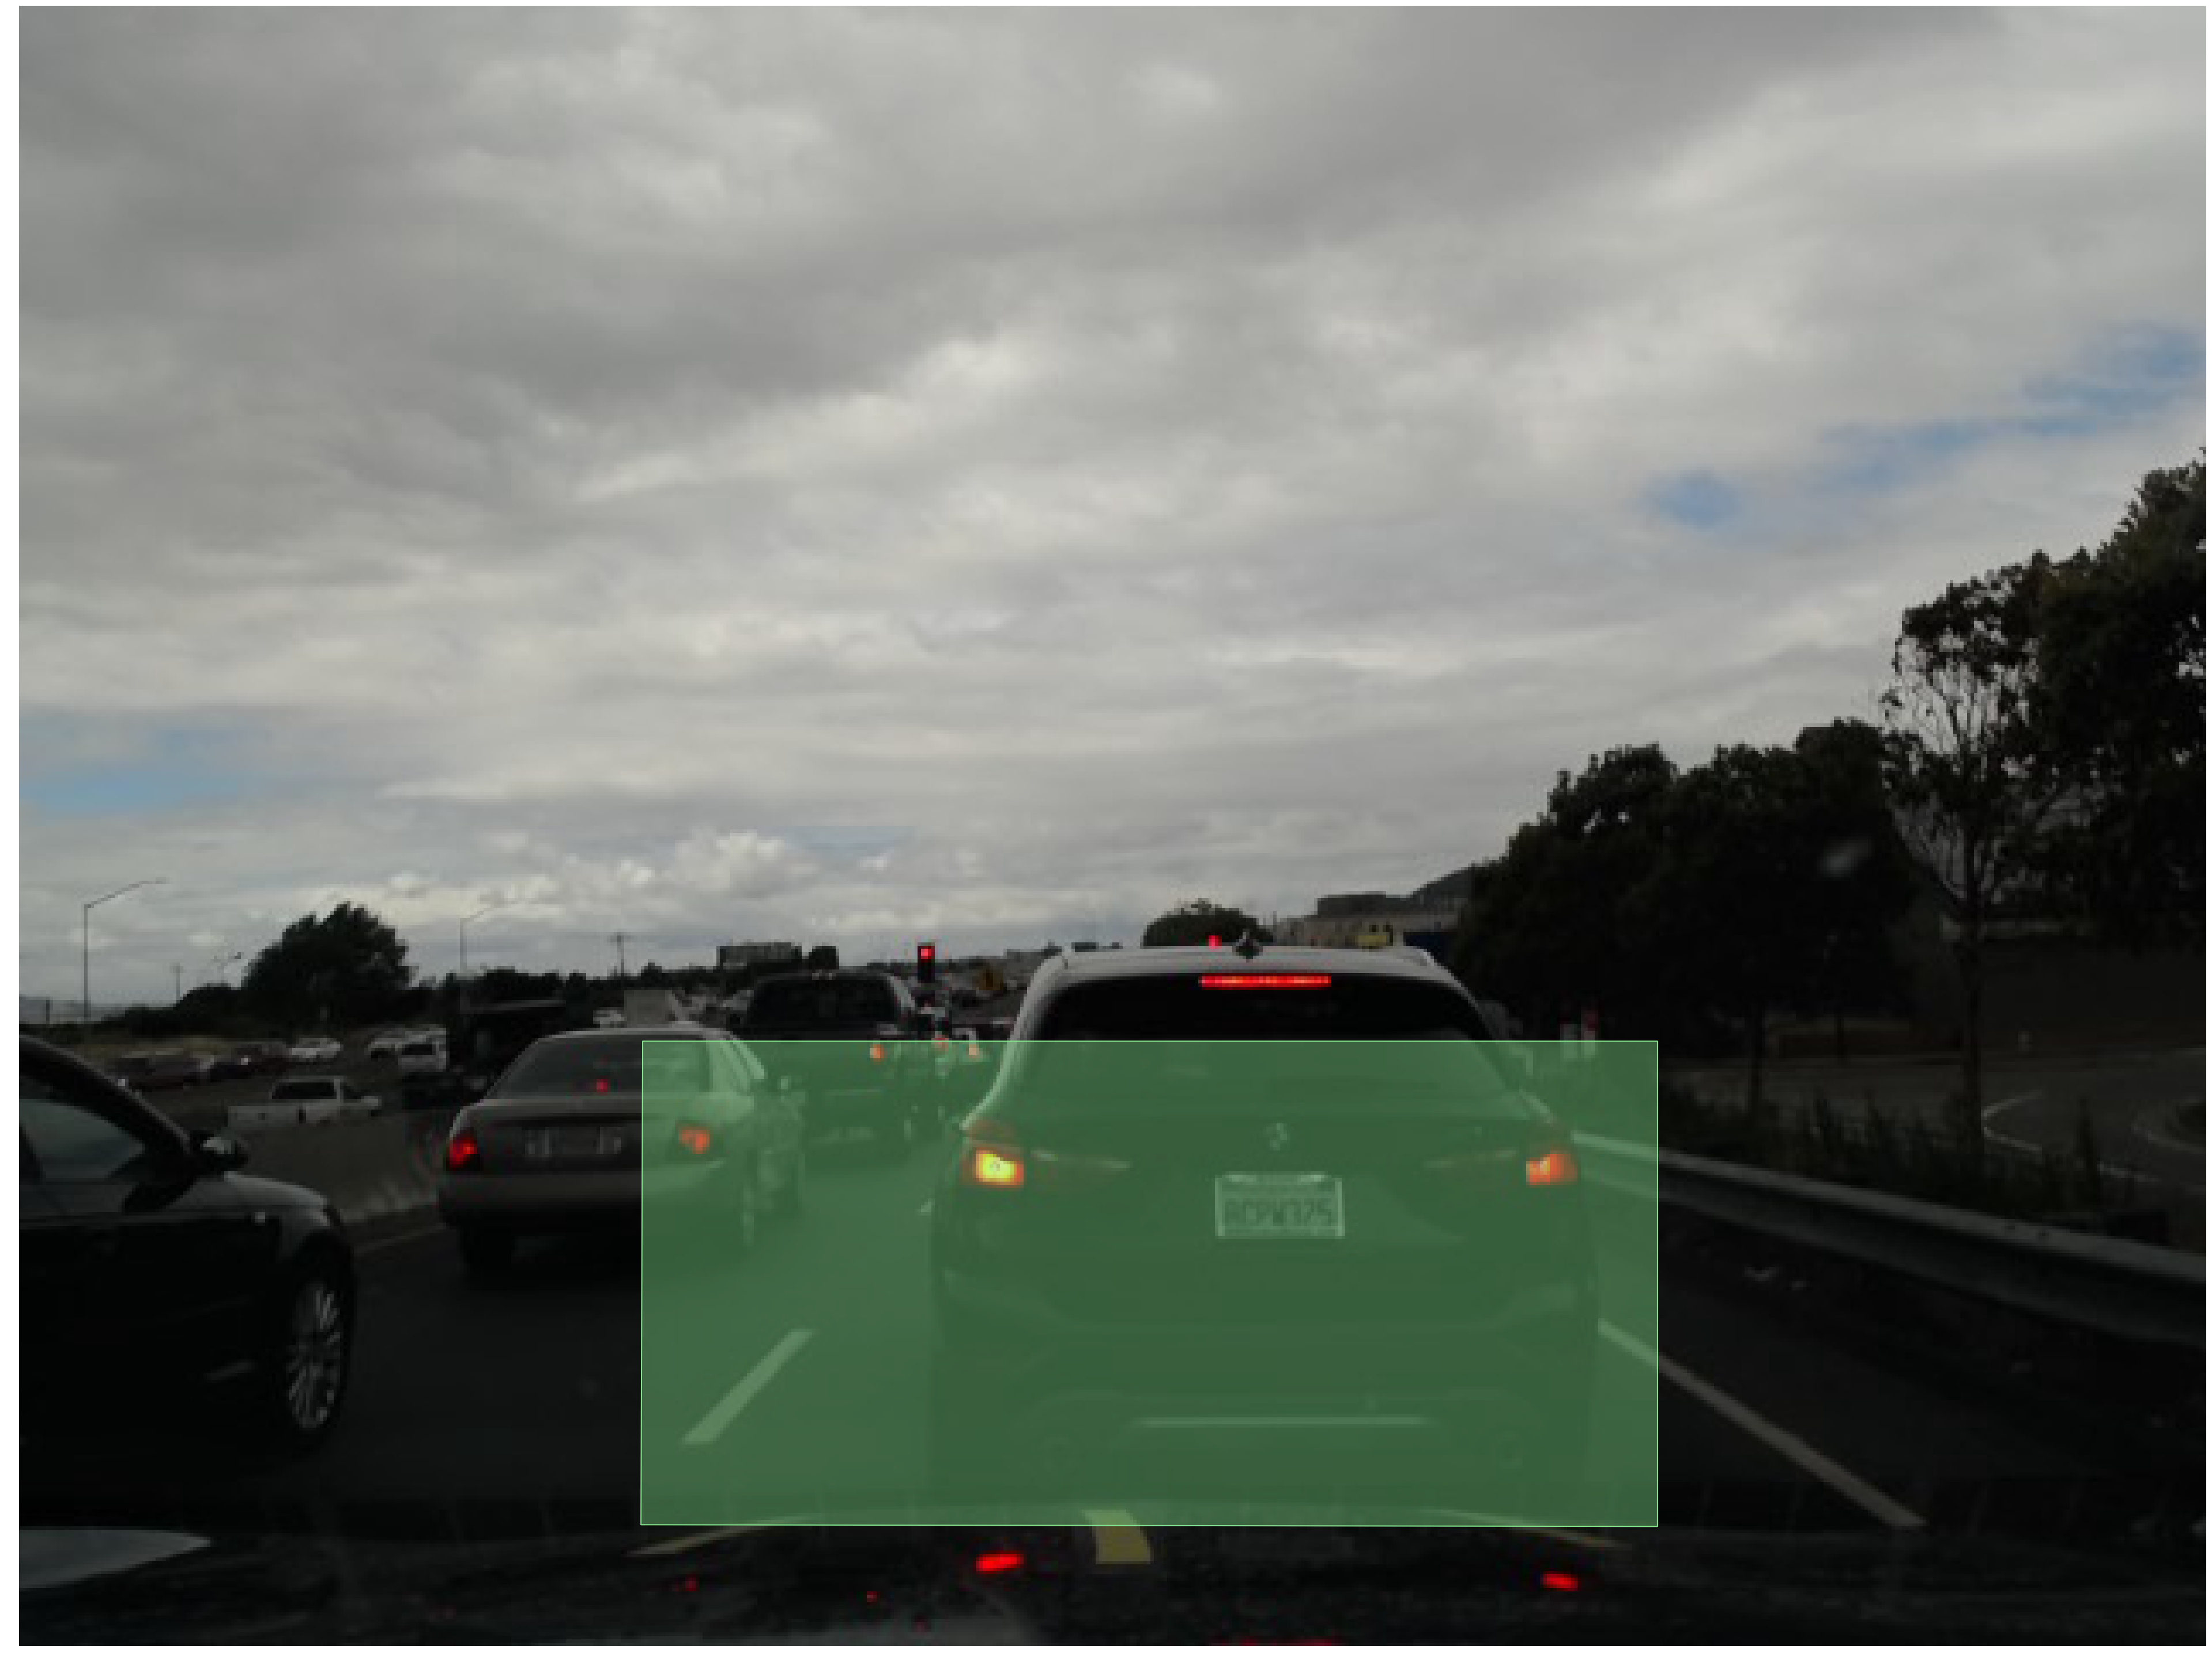

In [47]:
image_ids = example_coco.getImgIds()

image_data = example_coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])
print(image_data)

# load and display instance annotations
image = io.imread(os.path.join(image_directory ,image_data[0]['file_name']))
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (68.0, 120.0)
annotation_ids = example_coco.getAnnIds(imgIds=image_data[0]['id'])
annotations = example_coco.loadAnns(annotation_ids)
example_coco.showAnns(annotations)